In [874]:
import pandas as pd
pd.options.display.float_format = '{:,.1f}'.format
pd.set_option('max_colwidth',150)

## Evaluated models

In [2571]:
lang = "Hebrew"
model_type = ""
model_type = ""

path_repo = "/private/home/gulordava/colorlessgreen/data"
path_test_data = path_repo + "/agreement/" + lang + "/generated"
path_lm_data = path_repo + "/lm/"

path = "/private/home/gulordava/lstm_hyperparameters_exps/" + lang + "/" + model_type

In [2572]:
path_models = path + "/models/"
if model_type == "ngram_lstm":
    path_logs = path + "/logs/"
# wo OOV words
else:
    path_logs = path + "/valid_ppls/"

### Getting valid perplexity

In [2573]:
def get_test_score(f_name):
    ppls = []
    with open(f_name, "r") as f:
        for line in f:
            if "test " in line:
                fields = [f for f in line.strip().split("|") if f != ""][1:]
                values = [f.split()[-1] for f in fields]
                return float(values[-1])
            

Get perplexities for analysis

In [2574]:
import os
log_files = os.listdir(path_logs)
print(path_logs)

models_ppls = {}
for f in log_files:
    val_score = get_test_score(path_logs + f)
    if val_score:
        if model_type:
            m = "_".join([model_type, f[:-4]])
        else:
            m = f[:-4]
        models_ppls[m] = val_score
# best models
for f in sorted(models_ppls, key=models_ppls.get)[:10]:
    print(f, models_ppls[f])

top10 = sorted(models_ppls, key=models_ppls.get)[:5]

/private/home/gulordava/lstm_hyperparameters_exps/Hebrew//valid_ppls/
hidden650_batch64_dropout0.1_lr20.0 42.32
hidden650_batch128_dropout0.2_lr20.0 42.39
hidden650_batch64_dropout0.2_lr20.0 42.47
hidden650_batch64_dropout0.1_lr10.0 42.66
hidden650_batch128_dropout0.1_lr20.0 42.71
hidden650_batch64_dropout0.1_lr5.0 43.59
hidden650_batch128_dropout0.1_lr10.0 43.79
hidden650_batch64_dropout0.2_lr5.0 43.95
hidden650_batch64_dropout0.2_lr10.0 43.99
hidden650_batch128_dropout0.2_lr10.0 44.01


In [2575]:
%Rpush ppls

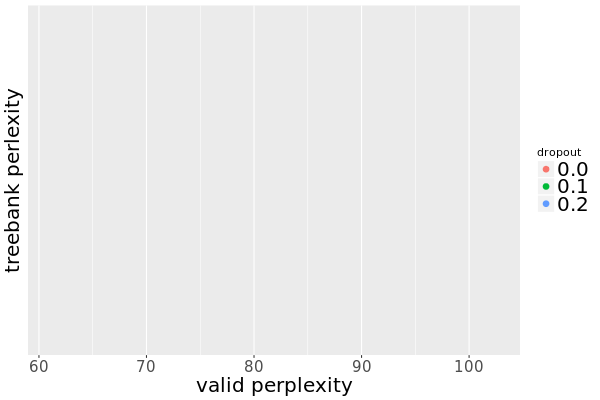

In [2576]:
%%R -w 600 -h 400

df = data.table(ppls)

text = element_text(size=20)
p = ggplot(df, aes(x=valid,y=treebank,color=dropout)) + xlab("valid perplexity") + ylab("treebank perlexity")
p + geom_point( size=2.5) + theme(axis.title.x=text, axis.title.y=text, legend.text=text, axis.text.x=element_text(size=15), 
          axis.text.y=element_text(size=15), strip.text=text)

Best 200 and 650 units models

In [2577]:
best_200 = sorted({f:models_ppls[f] for f in models_ppls if "hidden200" in f}, key=models_ppls.get)[:2]
best_650 = sorted({f:models_ppls[f] for f in models_ppls if "hidden650" in f}, key=models_ppls.get)[:2]
best = best_200 + best_650
for b in best:
    print(b, models_ppls[b])

hidden200_batch64_dropout0.1_lr10.0 57.52
hidden200_batch64_dropout0.1_lr5.0 57.62
hidden650_batch64_dropout0.1_lr20.0 42.32
hidden650_batch128_dropout0.2_lr20.0 42.39


## Computing accuracy

In [2578]:
import pandas as pd

# all models results
#full_df = pd.read_csv("/private/home/gulordava/colorlessgreen/data/results/" + lang + "_all_models.tab",sep="\t")
full_df = pd.read_csv("/private/home/gulordava/colorlessgreen/data/results/" + model_type + "/" + lang + "/all_models.tab",sep="\t")

In [2579]:
fields = ["pattern","constr_id","sent_id","n_attr","punct","len_prefix","len_context","sent","correct_number","type"]

In [2580]:
#models = list(models_ppls.keys()) + ["freq"]
#models = ["freq"]
models = [f for f in full_df.columns if "hidden" in f]  + ["freq"]

In [2581]:
wide_data = full_df[fields + ["class"] + models].pivot_table(columns=("class"),values=models,index=fields)

for model in models:
    correct = wide_data.loc[:, (model, "correct")]
    wrong = wide_data.loc[:, (model, "wrong")]
    wide_data[(model, "acc")] = correct > wrong
#wide_data.groupby("pattern_id").agg({"correct":"mean","wrong":"mean", "acc":["mean","size"]})
#wide_data.groupby("pattern_id").agg({}

In [2582]:
full_df["len_context"].mean()

4.597855227882038

In [2583]:
t = wide_data.reset_index()
#t = t[t.pattern == "L__NOUN_VERB_VERB"]
a = pd.concat([t.agg({(m,"acc"):"mean" for m in models}), 
           t[t.sent_id==0].agg({(m,"acc"):"mean" for m in models}),
           t[t.sent_id!=0].agg({(m,"acc"):"mean" for m in models})],
          axis=1)
a.index = models
a = a.reset_index()
a.columns = ["model","acc","acc_original","acc_generated"]
a.acc = a.acc * 100
a.acc_original = a.acc_original * 100
a.acc_generated = a.acc_generated * 100
#a.sort_values("acc")[-10:]

Best models by perplexity

In [2584]:
a["ppls"] = a["model"].map(models_ppls)


In [2585]:
properties = []
for row in a.model:
    if len(model_type) > 0:
        row = row[len(model_type) + 1:]
    if len(row.split("_")) >= 4:
        hidden, batch, dropout, lr = row.split("_")
        hidden = hidden[6:]
        batch = batch[5:]
        dropout = dropout[7:]
        lr = lr[2:]
    else:
        hidden, batch, dropout, lr = "_", "_","_", "_"
    properties.append([hidden, batch, dropout, lr])
properties = pd.DataFrame(properties, columns=["hidden","batch","dropout","lr"])

a = a.reset_index(drop=True).join(properties)

In [2586]:
a.sort_values("ppls")[:10]

,model,acc,acc_original,acc_generated,ppls,hidden,batch,dropout,lr
58,hidden650_batch64_dropout0.1_lr20.0,81.3,95.2,79.8,42.3,650,64,0.1,20.0
46,hidden650_batch128_dropout0.2_lr20.0,82.3,94.4,81.0,42.4,650,128,0.2,20.0
62,hidden650_batch64_dropout0.2_lr20.0,83.2,94.9,81.9,42.5,650,64,0.2,20.0
56,hidden650_batch64_dropout0.1_lr10.0,82.3,94.9,80.8,42.7,650,64,0.1,10.0
44,hidden650_batch128_dropout0.1_lr20.0,81.7,94.4,80.3,42.7,650,128,0.1,20.0
59,hidden650_batch64_dropout0.1_lr5.0,81.1,93.3,79.7,43.6,650,64,0.1,5.0
36,hidden650_batch128_dropout0.1_lr10.0,80.7,95.4,79.1,43.8,650,128,0.1,10.0
63,hidden650_batch64_dropout0.2_lr5.0,82.5,95.7,81.0,44.0,650,64,0.2,5.0
60,hidden650_batch64_dropout0.2_lr10.0,83.5,95.7,82.1,44.0,650,64,0.2,10.0
40,hidden650_batch128_dropout0.2_lr10.0,82.4,95.7,80.9,44.0,650,128,0.2,10.0


In [2587]:
a[a.model == "freq"]

,model,acc,acc_original,acc_generated,ppls,hidden,batch,dropout,lr
68,freq,63.6,67.8,63.1,nan,_,_,_,_


### Compute scores averaged for TOP 5 models

In [2588]:
a.sort_values("ppls")[:5][["acc","acc_original","acc_generated","ppls"]].agg(["mean","std"])

,acc,acc_original,acc_generated,ppls
mean,82.2,94.7,80.8,42.5
std,0.7,0.4,0.8,0.2


### Compute ensemble scores for TOP 5 models

In [2589]:
majority = []
for row in t[top10].iterrows():
    #print(row[1])
    majority.append(row[1].value_counts().idxmax())
t[("maj","acc")] = majority

In [2590]:
maj_models = models + ["maj"]
atop10 = pd.concat([t.agg({(m,"acc"):"mean" for m in maj_models}), 
           t[t.sent_id==0].agg({(m,"acc"):"mean" for m in maj_models}),
           t[t.sent_id!=0].agg({(m,"acc"):"mean" for m in maj_models})],
          axis=1)
atop10.index = maj_models
atop10 = atop10.reset_index()
atop10.columns = ["model","acc","acc_original","acc_generated"]
atop10.acc = atop10.acc * 100
atop10.acc_original = atop10.acc_original * 100
atop10.acc_generated = atop10.acc_generated * 100
atop10.sort_values("acc")[-10:]

,model,acc,acc_original,acc_generated
47,hidden650_batch128_dropout0.2_lr5.0,82.5,95.4,81.1
62,hidden650_batch64_dropout0.2_lr20.0,83.2,94.9,81.9
67,hidden650_batch64_dropout0.4_lr5.0,83.3,95.7,81.9
60,hidden650_batch64_dropout0.2_lr10.0,83.5,95.7,82.1
48,hidden650_batch128_dropout0.4_lr10.0,83.5,95.4,82.2
49,hidden650_batch128_dropout0.4_lr20.0,83.6,97.1,82.1
51,hidden650_batch128_dropout0.4_lr5.0,83.9,94.4,82.8
64,hidden650_batch64_dropout0.4_lr10.0,84.2,96.2,82.8
66,hidden650_batch64_dropout0.4_lr20.0,84.3,94.9,83.2
69,maj,84.6,97.1,83.2


## Overall accuracies and correlations

In [2591]:
#import pandas as pd
#a = pd.read_csv(path + "/accuracy.csv",sep="\t")

In [2592]:
print(len(a))
a.ppls.corr(a["acc"])

69


-0.55327256376346756

In [2593]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [2594]:
%Rpush a 

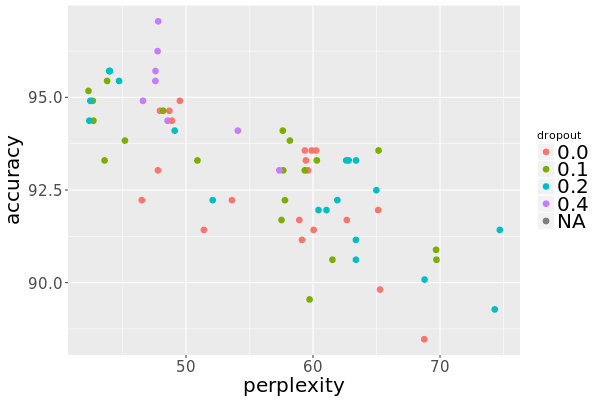

In [2595]:
%%R -w 600 -h 400
library(data.table)
library(ggplot2)

df = data.table(a)

text = element_text(size=20,family="ComputerModern")
p = ggplot(a[a$ppls<300 ,], aes(x=ppls,y=acc_original,color=dropout)) + xlab("perplexity") + ylab("accuracy")
p + geom_point( size=2.5) + theme(axis.title.x=text, axis.title.y=text, legend.text=text, axis.text.x=element_text(size=15), 
          axis.text.y=element_text(size=15), strip.text=text)

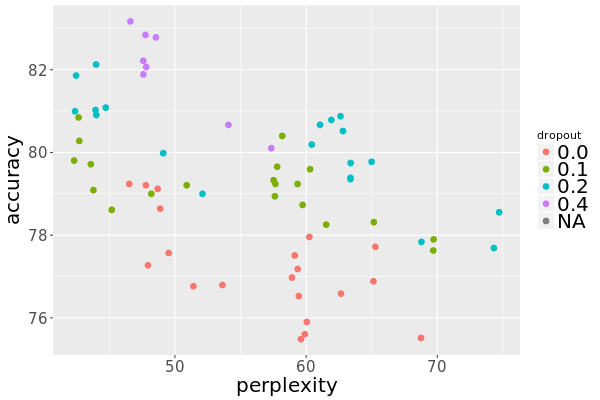

In [2596]:
%%R -w 600 -h 400
library(data.table)
library(ggplot2)

df = data.table(a)

text = element_text(size=20,family="ComputerModern")
p = ggplot(a[a$ppls<300 ,], aes(x=ppls,y=acc_generated,color=dropout)) + xlab("perplexity") + ylab("accuracy")
p + geom_point( size=2.5) + theme(axis.title.x=text, axis.title.y=text, legend.text=text, axis.text.x=element_text(size=15), 
          axis.text.y=element_text(size=15), strip.text=text)

## By-pattern evaluation

In [2597]:
len(av)

4

In [2598]:
len(mean)

4

In [2602]:
av = t[["pattern","type"] + top10].groupby(["pattern","type"]).mean()[[(m, "acc") for m in top10]]*100
mean = av.agg("mean",axis=1).reset_index()[0]
std = av.agg("std",axis=1).reset_index()[0]
av["top5_mean"] = list(mean)
av["top5_std"] = list(std)

av = av[["top5_mean","top5_std"]]
av = av.reset_index()
part1 = av[av["type"] == "generated"]
part1.columns = part1.columns.droplevel(1)
part2 = av[av["type"] == "original"]
part2.columns = part2.columns.droplevel(1)
part2["top5_mean_gen"] = list(part1["top5_mean"])
part2["top5_std_gen"] = list(part1["top5_std"])
part2

part2["pattern"] = [" ".join(p.split("_")[1:]) for p in list(part2["pattern"])]
part2["size"] = list(t.groupby("pattern").size())
part2.drop("type",axis=1)

/private/home/gulordava/anaconda3/lib/python3.6/site-packages/pandas/core/base.py:331: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  return self.obj.drop(self.exclusions, axis=1)
/private/home/gulordava/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
/private/home/gulordava/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/private/home/gu

,pattern,top5_mean,top5_std,top5_mean_gen,top5_std_gen,size
1,NOUN ADJ PROPN VERB,100.0,0.0,61.8,9.5,50
3,NOUN NOUN ADJ VERB,100.0,0.0,90.7,3.5,60
5,NOUN NOUN PROPN VERB,100.0,0.0,80.0,4.2,30
7,NOUN PROPN VERB,100.0,0.0,100.0,0.0,10
9,NOUN VERB PUNCT VERB,95.0,11.2,81.7,4.2,40
11,NOUN VERB VERB,86.7,9.3,65.7,4.1,90
13,NOUN ADJ DET ADJ,99.4,0.8,96.4,1.0,710
15,NOUN ADJ PUNCT SCONJ VERB,98.8,2.8,89.6,1.8,160
17,NOUN DET ADV PUNCT ADJ,93.3,5.3,81.2,4.6,300
19,NOUN NOUN DET ADJ,94.2,1.0,77.6,0.9,1520


In [2600]:
top = t[top10]
#t.groupby("pattern").mean()

In [2601]:
t[top10 + ["acc","acc_original","acc_generated","ppls","pattern"]].agg(["mean","std"])

KeyError: "['acc' 'acc_original' 'acc_generated' 'ppls'] not in index"